# **Monthly Reporting of Fraud Global Metrics**

## <span style='color:orange'>Summary:</span>

**Prepared Fraud Global Metrics data to be clean and deduplicated. Accuracy is guaranteed for this report.**


**Total 30,749 fraud global metrics fired in April 2023.**
**Total 1,719 unique active fraud global metrics defined in SharePoint in April 2023.** (As we identified the active metrics, some of them are not in production. We'll be reaching out to those metrics owners for possible decommission.)

**Summary of 3 execution results of fraud global metrics SAS jobs:**

-  Total 10,379 (33.8%) metrics have **No New Data** because datasource unavailable or data not meet selection criteria.

-  Total 890 (2.9%) metrics are **Out Of Range** (+- 2 standard deviations).

-  Total 19,480 (63.4%) metrics are within **Normal Range**.


**The current Fraud Global Metrics has default 2.5 standard deviations for alerting Out-of-Range values. However, for the following analysis, by simulating 5 standard deviations, we identified <span style='color:red'>High Alerts</span> by Strategy Team. We saw 3 teams had High Alerts in April 2023:**

-  **'Payment' Team**: Metric 15.01 (Total Payment) and 15.04 (Average Payment Amount).

-  **'Account Security' Team**: Metric 24 (iOvation Allowed Volume), 24.2 (iOvation Allowed Non-Acquisition Volume), 24.2002 (iOvation Allowed MobileLogin volume) and 90.1(Iovation Rules Total).

-  **'Transaction' Team**: Metric 100 (Total Transactions), 100.0001 (Total Visa Transactions), 100.0010 (Approved Transactions), 100.0011 (Approved Visa Transactions), 100.0020 (Declined Transactions), 100.0100 (Total Distinct Cards Transacted), 100.0101 (Total Distinct Visa Cards Transacted), 100.0110 (Approved Distinct Cards Transacted), 101.0100 (Total Chip on Chip), 101.0800 (Total CNP Tokenized),101.0801 (Total Visa CNP Tokenized),101.0900	(Total CP Tokenized), 101.0901 (Total Visa CP Tokenized), 101.0910	(Approved CP Tokenized), 101.0911	(Approved Visa CP Tokenized).


**Job running issue of Fraud Global Metrics:**

-  During April 11-April 15, as part of IT's cleaning process, our metrics SAS datasets got accidentally deleted. 
   The issue has been resolved on April 16, we worked with IT to recover SAS datasets located in UNIX folders the program uses. After the SAS datasets were recovered, the job had the required historical data to execute identifying the out-of-range metrics for the daily email report.


**Total 4 of new Fraud Global Metrics jobs deployed in April 2023:**

-  FGMDY159_Velocity_Tables.sas
-  FGMDY105_CAS.sas
-  FGMDY128_Crosscore.sas
-  FGMDY128_Applications.sas


**Enhancements on Fraud Global Metrics so far:**

-  Added new column 'Reason' on daily Fraud Global Metrics email to explain the reason why there is no new data for that day.

-  Synchronized Fraud Global Metrics SQL database with Sharepoint and Tableau. The benefit is to replicate Sharepoint changes to SQL database instantly.

-  Performed a in-depth review of Fraud Global Metrics parent job FGMDY000.sas (how it handles metrics calculations and generating daily emails) and identified opportunities for future enhancement.


**Future enhancements:**

-  Create new function: customized tolerance for prediction values (Currently defaults to 2.5 standard deviations) and will allow users to define different standard deviations depending on their strategies.

-  Automate the manual refresh process of Fraud Global Metrics in order to mitigate failure points when deploying metrics jobs.




## <span style='color:orange'>1. Data Cleaning (data type issue, duplicates)</span>

<span style='color:orange'>1.1 Import April Metrics Data</span>

In [2]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import numpy as num
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import numpy as np


In [3]:
conn=pyodbc.connect('Driver={SQL Server};'
                     'Server=LASINFSQL01;'
                     'Trusted_Connection=yes;')
gm=\
    pd.read_sql_query('''
    select *
    FROM [RiskFraud].[dbo].[V_FGM_073_Tab_GlobalMetrics]
    where createdate>='2023-04-01' and reportingdate<'2023-05-01'
    order by metricid, ReportingDate

    ''',conn)                  

C:\Users\mzhao\AppData\Local\Temp\ipykernel_13212\2636954358.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query('''


In [4]:
# standardize data types
gm.dtypes
# a function to check whether there is any unexpected special symbol
def if_contain_symbol(keyword):
    symbols = "~!@#$%^&*()_+*/<>,[]\/"
    for symbol in symbols:
        if symbol in keyword:
            return symbol
    else:
        return False
if_contain_symbol(gm[['ReportingDate','CreateDate','Strategy','Metric','Developer']].to_string())
print('Found special symbol:It is normal to have $ in metric.')

Found special symbol:It is normal to have $ in metric.


<span style='color:orange'>1.2 Data cleaning & sorting: Removed duplicatesa and failed execution data
</span>

In [5]:
gm['dupornot']=gm.duplicated()

#show duplicated rows (True dup, with all columns duplicated), "size" is the num of dups
truedups=gm[gm['dupornot']==True].groupby(['MetricID','ReportingDate','Count','CreateDate','DollarValue','Strategy','Metric','Developer']).size().to_frame('size').reset_index().sort_values(['MetricID','CreateDate'],ascending=True)

#dedup by all columns
gm.drop_duplicates(subset=['MetricID','ReportingDate','Count','CreateDate','DollarValue','Strategy','Metric','Developer'],keep='first',inplace=True)

#dedup by MetricID & ReportingDate
gm.drop_duplicates(subset=['MetricID','ReportingDate'],keep='first',inplace=True)

# show reportingdate nulls
gm[pd.isnull(gm['ReportingDate'])]
#drop
gm.dropna(subset = ['ReportingDate'],inplace=True)

#show count nulls (appear as NO NEW DATA)
gmnulls=gm[pd.isnull(gm['Count'])]
# fill with 0
gm['Count']=gm['Count'].fillna(0)

gm['DollarValue']=gm['DollarValue'].fillna(0)

Data All Clean.

In [6]:
gm.isnull().sum()

MetricID         0
ReportingDate    0
Count            0
CreateDate       0
DollarValue      0
Strategy         0
Metric           0
Developer        0
dupornot         0
dtype: int64

## <span style='color:green'>2. Visualizations</span>

In [8]:
gmvisual=\
    pd.read_sql_query('''
    select *
    FROM [RiskFraud].[dbo].[AprilMetrics]
    order by metricid, reportdate

    ''',conn)


C:\Users\mzhao\AppData\Local\Temp\ipykernel_13212\3837802877.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query('''


In [9]:
#gmvisual is a dataframe used for all visualizations below.
gmvisual['OutOfRange_DollarValue'].unique()
gmvisual['OutOfRange_DollarValue'].fillna('No OutOfRange', inplace=True)
gmvisual[gmvisual['OutOfRange_DollarValue']=='*']='With OutOfRange'


<span style='color:green'>2.1 Summary of Execution Results, April 2023</span>

Text(0.5, 1.0, 'Summary of RiskFraud Global Metrics Execution Result, Apr 2023')

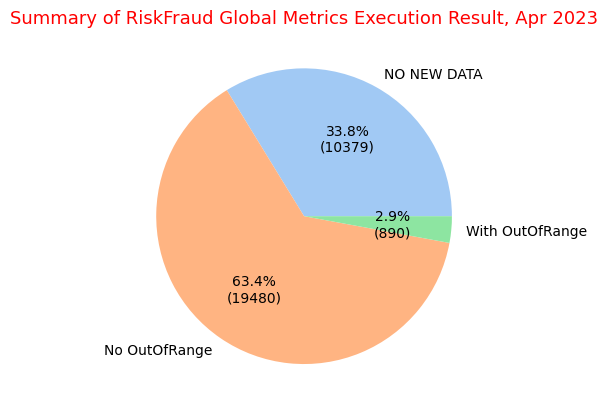

In [10]:
#gmpie is a dataframe used for Pie Chart plot
gmpie=gmvisual.groupby(['OutOfRange_DollarValue']).size().to_frame('Nums').reset_index()

#pie plotting:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format
labels=gmpie['OutOfRange_DollarValue']
plt.pie(gmpie['Nums'],labels = labels, colors = sns.color_palette('pastel'),autopct=autopct_format(gmpie['Nums']))
plt.title('Summary of RiskFraud Global Metrics Execution Result, Apr 2023',color = 'red',fontsize = 13)


<span style='color:green'>2.2 Highly alerting Out-Of-Range metrics (>=5 Standard Deviations), breaking down by strategy team, Apr 2023:

***FYI: Curreently Daily alerting email we received is based on 2 Standard Deviations. However, this analysis below is for discovering high alerts (>= 5 Standard Deviations).</span>***

In [21]:
gmvisual=\
    pd.read_sql_query('''
    select *
    FROM [RiskFraud].[dbo].[AprilMetrics]
    order by metricid, reportdate

    ''',conn)


C:\Users\mzhao\AppData\Local\Temp\ipykernel_13212\3837802877.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query('''


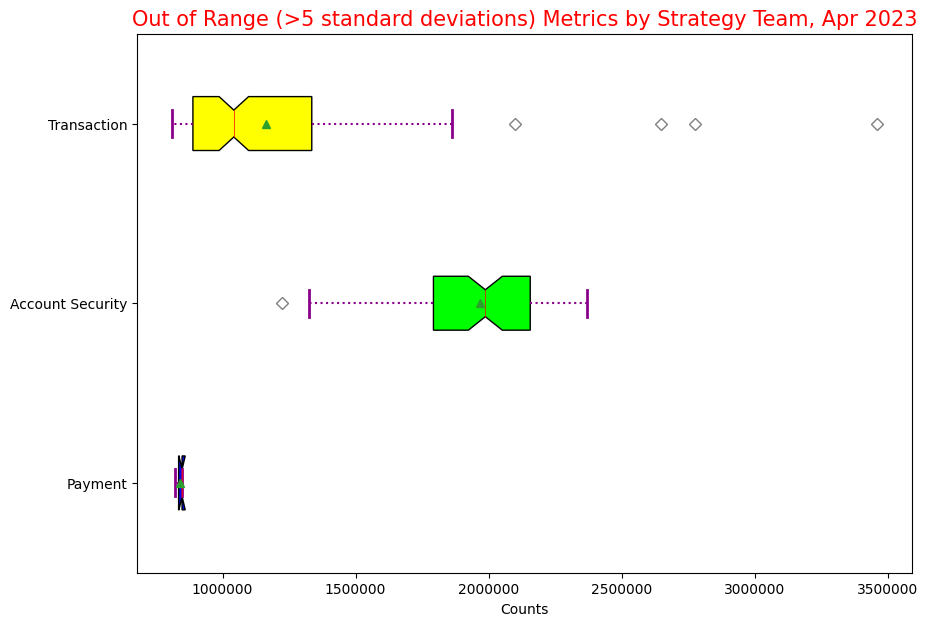

In [28]:
# any value with a Z socre out of threshold 5 will be considered as an outlier
import numpy as np
df = gmvisual['Count'].fillna(0)
threshold = 5
mean = np.mean(df)
std = np.std(df)
outlier = []
for i in df.tolist(): 
    zscore = (i-mean)/std 
    if zscore > threshold: 
        outlier.append(i)

#plot size
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

#define data
gmbox=gmvisual.loc[gmvisual['Count'].isin(outlier)][['Strategy','MetricID','Metric','ReportDate','Count']]
gmpayment=gmbox[gmbox['Strategy']=='Payment'].reset_index(drop=True)
gmaccs=gmbox[gmbox['Strategy']=='Account Security'].reset_index(drop=True)
gmtrans=gmbox[gmbox['Strategy']=='Transaction'].reset_index(drop=True)
gmtrans.drop_duplicates(keep='first',inplace=True)
data=[gmpayment['Count'],gmaccs['Count'],gmtrans['Count']]

# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0,showmeans=True)
colors = ['#0000FF', '#00FF00',
          '#FFFF00']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 0.5)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
# y-axis labels
ax.set_yticklabels(['Payment', 'Account Security',
                    'Transaction'])
ax.set_xlabel('Counts')


plt.ticklabel_format(style='plain', axis='x')

plt.title("Out of Range (>5 standard deviations) Metrics by Strategy Team, Apr 2023",color = 'red',fontsize = 15)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()


FYI: Triangles represent Mean value. Diamonds represent High Alerts (> 5 standard deviations). This boxplot shows the distribution of Counts (volume) of metrics by different teams. 

<span style='color:green'>2.3 A closer look into High Alerts for **Payment** strategies:</span>

In [23]:
pd.set_option('display.max_rows', None)
gmpayment

,Strategy,MetricID,Metric,ReportDate,Count
0,Payment,15.01,Total Payment,2023-04-28,848075.0
1,Payment,15.04,Average Payment Amount,2023-04-14,822078.0
2,Payment,15.04,Average Payment Amount,2023-04-28,848075.0


<span style='color:green'>2.4 A closer look into High Alerts for **Account Security** strategies:</span>

In [24]:
gmaccs

,Strategy,MetricID,Metric,ReportDate,Count
0,Account Security,24.0000,iOvation Allowed Volume,2023-04-09,1324598.0
1,Account Security,24.0000,iOvation Allowed Volume,2023-04-10,2141968.0
2,Account Security,24.0000,iOvation Allowed Volume,2023-04-11,2230027.0
3,Account Security,24.0000,iOvation Allowed Volume,2023-04-12,2250457.0
4,Account Security,24.0000,iOvation Allowed Volume,2023-04-13,2340583.0
5,Account Security,24.0000,iOvation Allowed Volume,2023-04-14,2341119.0
6,Account Security,24.0000,iOvation Allowed Volume,2023-04-15,1867205.0
7,Account Security,24.0000,iOvation Allowed Volume,2023-04-16,1633704.0
8,Account Security,24.0000,iOvation Allowed Volume,2023-04-17,2152562.0
9,Account Security,24.0000,iOvation Allowed Volume,2023-04-18,2179806.0


<span style='color:green'>2.5 A closer look into High Alerts for **Transaction** strategies:</span>

In [29]:
gmtrans

,Strategy,MetricID,Metric,ReportDate,Count
0,Transaction,100.0000,Total Transactions,2023-04-10,1640609.0
1,Transaction,100.0000,Total Transactions,2023-04-11,1735503.0
2,Transaction,100.0000,Total Transactions,2023-04-12,1691626.0
3,Transaction,100.0000,Total Transactions,2023-04-13,1714537.0
4,Transaction,100.0000,Total Transactions,2023-04-14,1705400.0
6,Transaction,100.0000,Total Transactions,2023-04-16,1529331.0
7,Transaction,100.0000,Total Transactions,2023-04-17,1674099.0
8,Transaction,100.0000,Total Transactions,2023-04-18,1757179.0
9,Transaction,100.0000,Total Transactions,2023-04-19,1769972.0
10,Transaction,100.0000,Total Transactions,2023-04-20,3458046.0


<span style='color:green'>2.6 Summary of High Alerts by Strategy:</span>

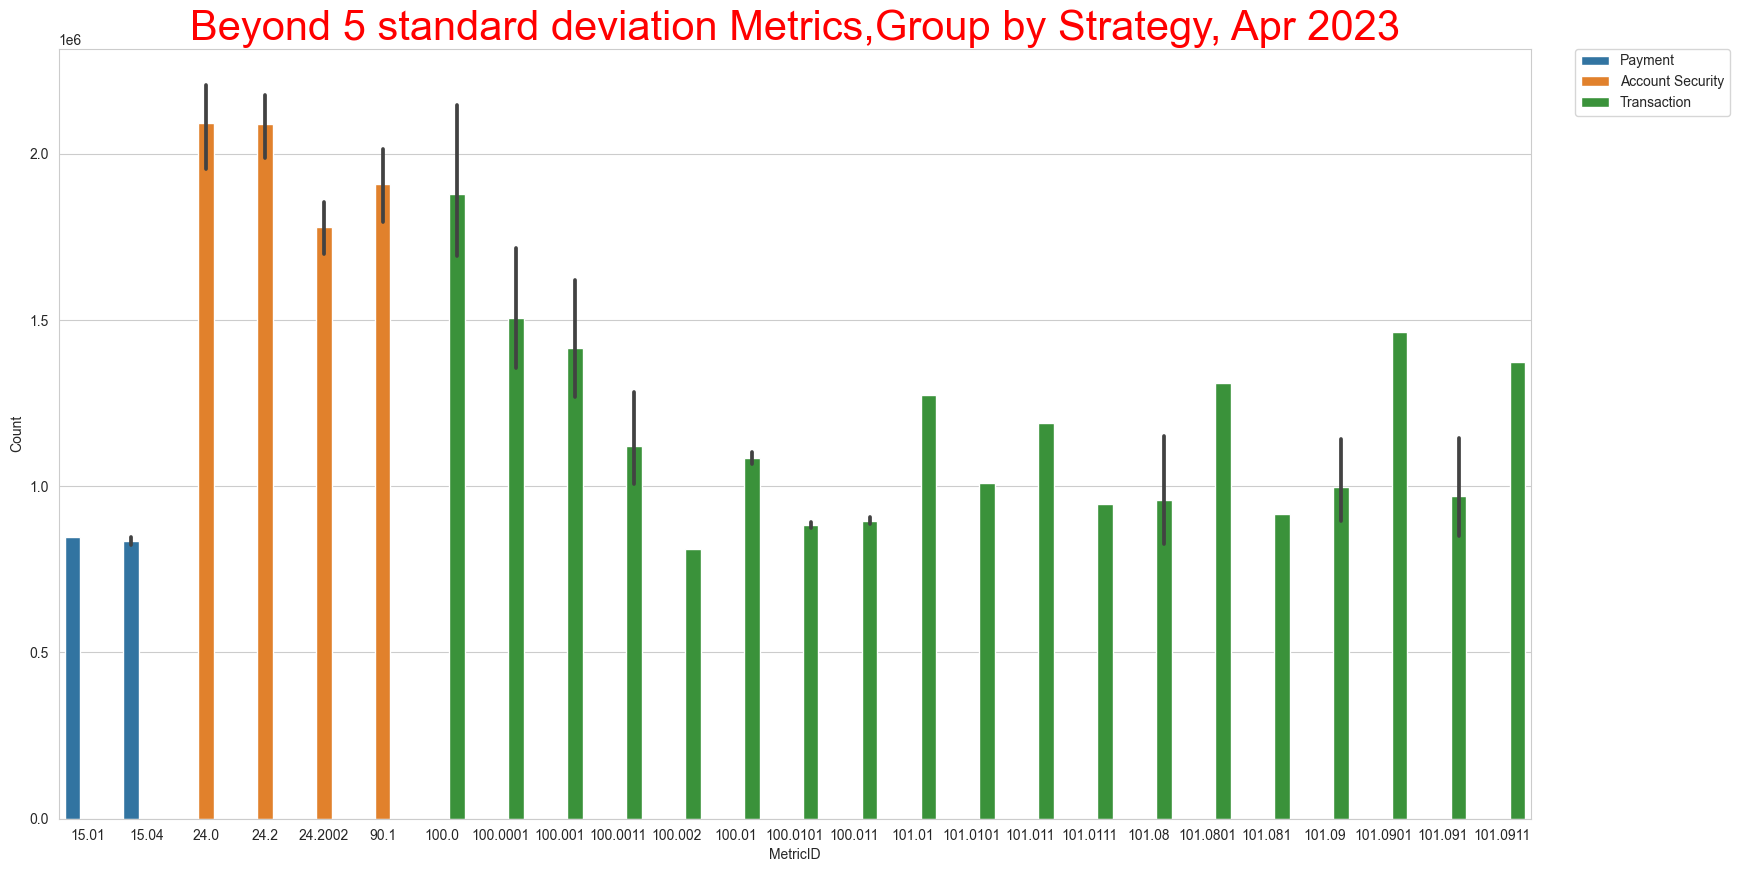

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize = (19,10))
plt.xlabel('Metric ID')
plt.ylabel('Counts')
plt.title('Top 10 busiest round route')
sns.barplot(data=gmbox, x='MetricID', y = 'Count', hue='Strategy').set_title('Beyond 5 standard deviation Metrics,Group by Strategy, Apr 2023',fontdict={'size': 30,'color': 'red'})
plt.legend(bbox_to_anchor=(1.03,1), loc=2, borderaxespad=0.)

<span style='color:green'>2.7 Summary of High Alerts by Strategy, Team:</span>

c:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26 () missing from current font.
  func(*args, **kwargs)
c:\Program Files\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


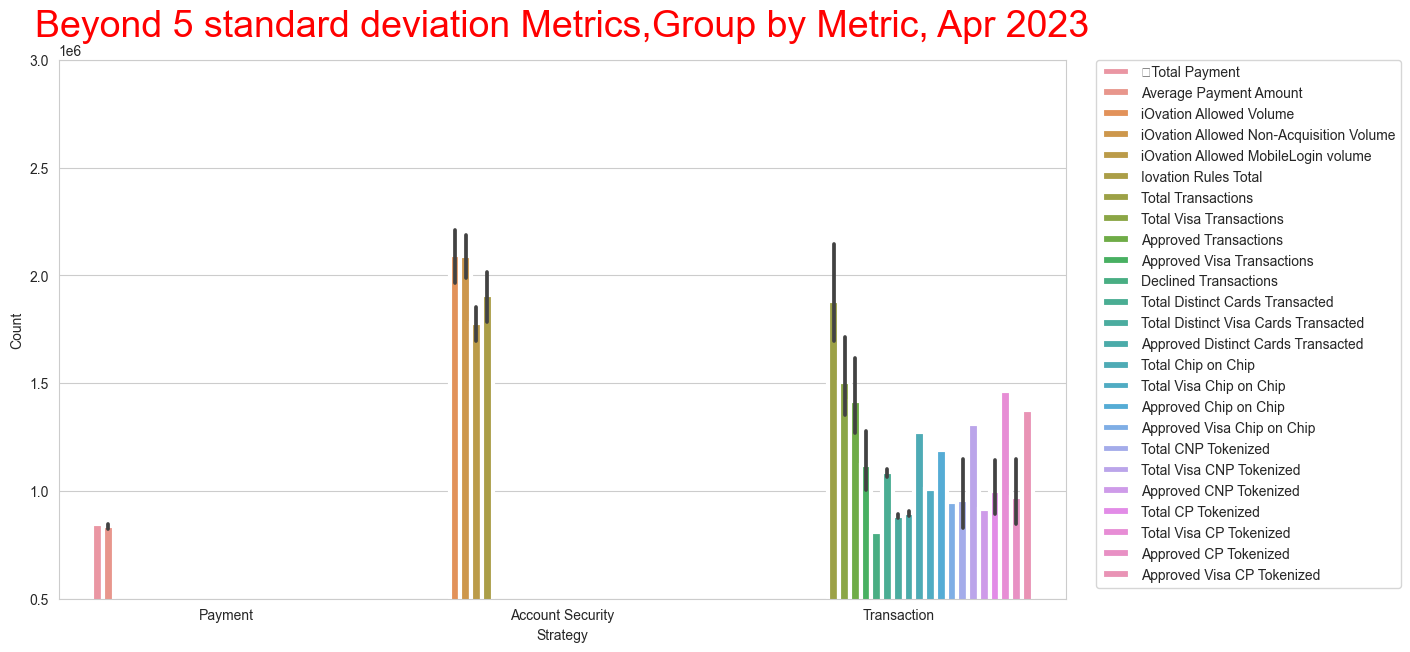

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize = (13,7))
plt.xlim(500000,3000000)
plt.ylim(500000,3000000)
ax=sns.barplot(data=gmbox, x='Strategy', y = 'Count', hue='Metric',linewidth = 3).set_title('Beyond 5 standard deviation Metrics,Group by Metric, Apr 2023',fontdict={'size': 27,'color': 'red'})
plt.legend(bbox_to_anchor=(1.03,1), loc=2, borderaxespad=0.)
